# Imports

In [17]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import os
import pathlib
import math
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
print(tf.__version__)

2.10.0


# Hyperparameters

In [3]:
batch_size = 32
img_height = 224
img_width = 224
lr_rate = 1e-3
lr_mode = 'cos'
epochs = 10
data_dir = pathlib.Path(r"C:\Users\Jagan\Desktop\ML\skin_disease\Augmented Images\Augmented Images\FOLDS_AUG\fold1_AUG\Train").with_suffix('')

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 7518 files belonging to 6 classes.
Using 6015 files for training.
Found 7518 files belonging to 6 classes.
Using 1503 files for validation.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


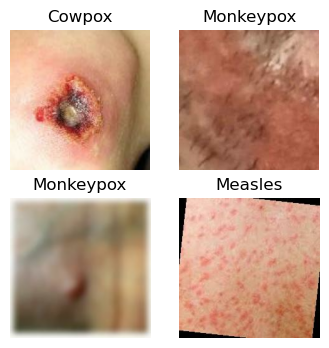

In [5]:
plt.figure(figsize=(4, 4))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalization

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Model

In [8]:
base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [9]:
base_model.trainable = False

In [10]:
inputs = keras.Input(shape=(img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(6)(x)

model = keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         9437696   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                             

# LR Callback

In [12]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 6e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

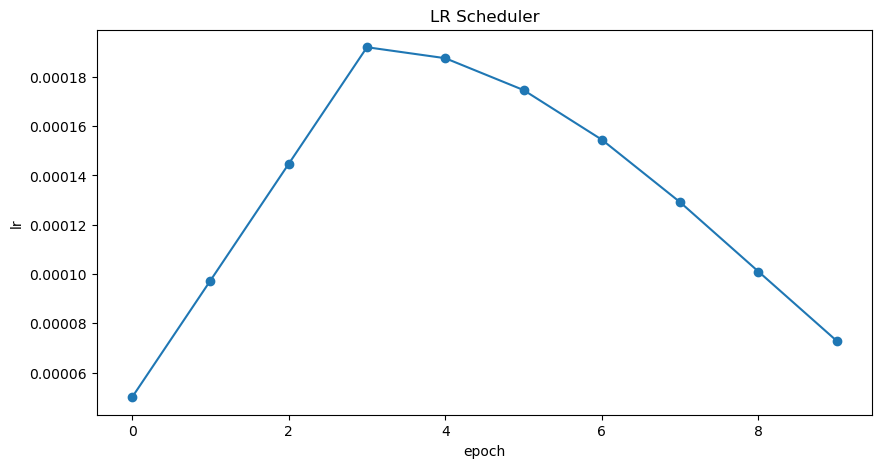

In [13]:
lr_cb = get_lr_callback(batch_size, mode=lr_mode, plot=True, epochs=epochs)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training

In [15]:
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[early_stopping, lr_cb],
    validation_data=train_ds)

Epoch 1/10
188/188 [==============================] - 263s 1s/step - loss: 0.5304 - accuracy: 0.8057 - val_loss: 0.1928 - val_accuracy: 0.9443 - lr: 5.0000e-05
Epoch 2/10
188/188 [==============================] - 229s 1s/step - loss: 0.2216 - accuracy: 0.9237 - val_loss: 0.0977 - val_accuracy: 0.9716 - lr: 9.7333e-05
Epoch 3/10
188/188 [==============================] - 229s 1s/step - loss: 0.1595 - accuracy: 0.9393 - val_loss: 0.1009 - val_accuracy: 0.9639 - lr: 1.4467e-04
Epoch 4/10
188/188 [==============================] - 229s 1s/step - loss: 0.1334 - accuracy: 0.9541 - val_loss: 0.0527 - val_accuracy: 0.9817 - lr: 1.9200e-04
Epoch 5/10
188/188 [==============================] - 230s 1s/step - loss: 0.0973 - accuracy: 0.9663 - val_loss: 0.0571 - val_accuracy: 0.9807 - lr: 1.8755e-04
Epoch 6/10
188/188 [==============================] - 230s 1s/step - loss: 0.0449 - accuracy: 0.9862 - val_loss: 0.0246 - val_accuracy: 0.9925 - lr: 1.7462e-04
Epoch 7/10
188/188 [====================

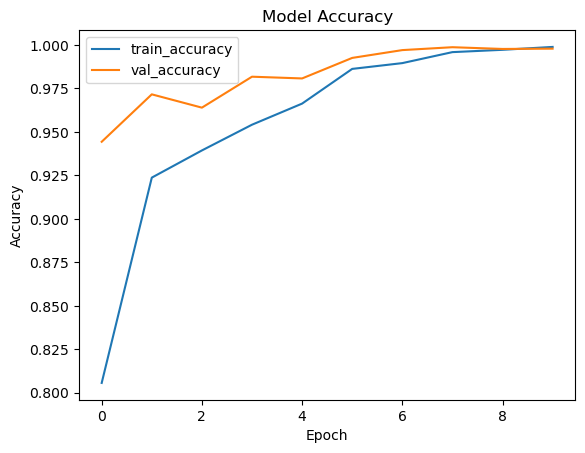

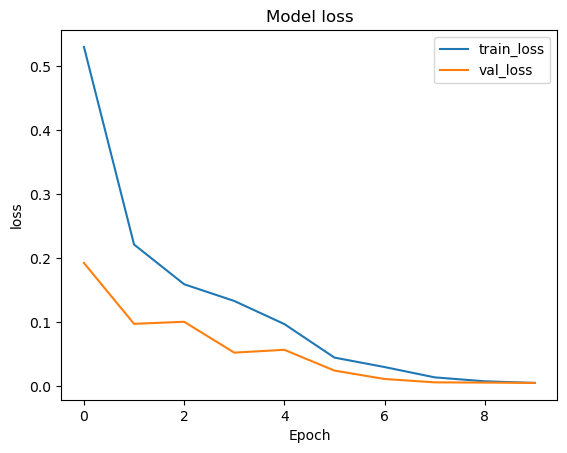

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# Testing

In [21]:
test_data_dir = r"C:\Users\Jagan\Desktop\ML\skin_disease\Original Images\Original Images\Testing"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=50,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 661 files belonging to 6 classes.
21/21 [==============================] - 14s 638ms/step - loss: 0.2602 - accuracy: 0.9637


[0.2602483630180359, 0.9636913537979126]

In [23]:
model.save("final_model.h5")

# Testing model loading

In [19]:
model = keras.models.load_model(r"C:\Users\Jagan\Desktop\ML\final_model.h5", compile=False)

In [21]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_rate),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
test_data_dir = r"C:\Users\Jagan\Desktop\ML\skin_disease\Original Images\Original Images\Testing"
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=50,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 661 files belonging to 6 classes.


In [23]:
model.evaluate(test_ds)

21/21 [==============================] - 4s 100ms/step - loss: 0.2602 - accuracy: 0.9637


[0.2602495551109314, 0.9636913537979126]

In [24]:
class_names = ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

21/21 [==============================] - 3s 97ms/step


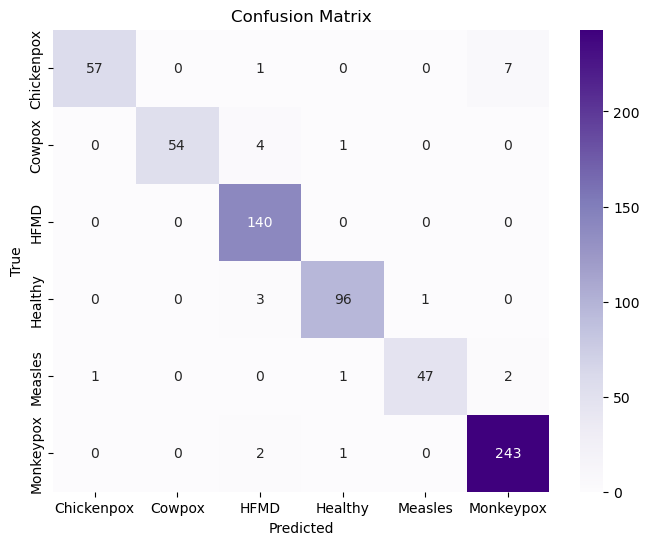

              precision    recall  f1-score   support

  Chickenpox       0.98      0.88      0.93        65
      Cowpox       1.00      0.92      0.96        59
        HFMD       0.93      1.00      0.97       140
     Healthy       0.97      0.96      0.96       100
     Measles       0.98      0.92      0.95        51
   Monkeypox       0.96      0.99      0.98       246

    accuracy                           0.96       661
   macro avg       0.97      0.94      0.96       661
weighted avg       0.96      0.96      0.96       661



In [52]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))